# Libaries

In [107]:
# Data-handling libraries
import pandas as pd

# Text-handling libaries
from nltk.corpus import stopwords

# Reshaping imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Modeling imports
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Other imports
import matplotlib.pyplot as plt
plt.style.use("alex")

# Options
seed = 5777

# Model data

## Import data

In [3]:
# Don't "intelligently" (in BIG scare quotes) filter out NA values
# or else we end up dropping naan bread (spelled "nan"). :facepalm:
df = pd.read_csv("data/Dishes-by-year.csv.bz2", na_filter=False)

## Split data

In [138]:
df.groupby("decade")["name"].count().sort_values()

decade
1870       174
2010      1416
2000      1482
1850      2244
1860      2892
1990      3852
1880     12748
1980     20573
1920     21832
1970     25294
1890     56279
1960     62820
1940     73904
1950     81870
1930    123098
1910    380510
1900    402581
Name: name, dtype: int64

In [154]:
# We want each class to have only as many as the smallest class
#sample_size = df.groupby("decade")["name"].count().min()
sample_size = df.groupby("decade")["name"].count().sort_values().iloc[2]

# Sample randomly from each decade <https://stackoverflow.com/a/56841648>
sample = df.sample(frac=1, random_state=seed).groupby("decade").head(sample_size)

In [155]:
X = sample["tokens"]
y = sample["decade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

## Define baseline

In [137]:
# Baseline probability allocation
y

373993    1930
206959    1900
414179    1910
656486    1980
512061    1890
          ... 
721631    1870
721622    1870
227929    1870
721725    1870
721641    1870
Name: decade, Length: 2958, dtype: int64

## Options for all models

In [6]:
cv_folds = 3
verbosity = 3

tfidf = TfidfVectorizer(
                stop_words = "english",
                strip_accents = "ascii"
            )

## Naïve Bayes classifier

In [156]:
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

bayes = GaussianNB().fit(X_train_vec.toarray(), y_train)

In [157]:
print("Train:", bayes.score(X_train_vec.toarray(), y_train))
print("Test:", bayes.score(X_test_vec.toarray(), y_test))

Train: 0.517772180240694
Test: 0.22401343408900085


In [159]:
def fuzzy_accuracy(y_true, y_pred, tolerance):
    return np.mean(np.abs(y_true - y_pred) <= tolerance)

print("Train:", fuzzy_accuracy(y_train, bayes.predict(X_train_vec.toarray()), tolerance=10))
print("Test:", fuzzy_accuracy(y_test, bayes.predict(X_test_vec.toarray()), tolerance=10))

Train: 0.6194794290512174
Test: 0.40890008396305627


In [101]:
y_train

707035     1850
475377     1940
700572     1890
445997     1880
680041     1970
           ... 
946512     1980
966997     1990
28988      1930
1256823    1990
774044     1910
Name: decade, Length: 2218, dtype: int64

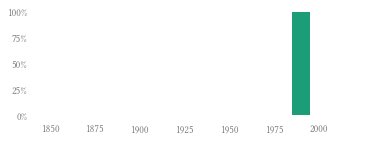

In [143]:
item = "tofu"

fig, ax = plt.subplots(figsize=(6, 2))
ax.bar(
    list(range(1850, 2020, 10)),
    bayes.predict_proba(tfidf.transform([item]).toarray())[0] * 100,
    width=10
)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d%%"))

In [153]:
bayes.predict_proba(tfidf.transform(["de"]).toarray())

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [10]:
pipe1 = Pipeline([
        ("tfidf", tfidf),
        ("bayes", GaussianNB())
    ])

grid1 = GridSearchCV(pipe1, {
    "tfidf__max_features": [5_000, 10_000, 50_000],
}, cv=cv_folds, verbose=verbosity)

In [11]:
grid1.fit(X_train, y_train)
print(grid1.best_score_, "with", grid1.best_params_)
print("Test:", grid1.score(X_test, y_test))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] tfidf__max_features=5000 ........................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ut

[CV] .............. tfidf__max_features=5000, score=nan, total=   3.7s
[CV] tfidf__max_features=5000 ........................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ut

[CV] .............. tfidf__max_features=5000, score=nan, total=   3.7s
[CV] tfidf__max_features=5000 ........................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ut

[CV] .............. tfidf__max_features=5000, score=nan, total=   3.8s
[CV] tfidf__max_features=10000 .......................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ut

[CV] ............. tfidf__max_features=10000, score=nan, total=   3.8s
[CV] tfidf__max_features=10000 .......................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ut

[CV] ............. tfidf__max_features=10000, score=nan, total=   3.8s
[CV] tfidf__max_features=10000 .......................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ut

[CV] ............. tfidf__max_features=10000, score=nan, total=   3.6s
[CV] tfidf__max_features=50000 .......................................


KeyboardInterrupt: 

## Decision tree classifier

In [8]:
pipe2 = Pipeline([
        ("tfidf", tfidf),
        ("tree", DecisionTreeClassifier())
    ])

grid2 = GridSearchCV(pipe2, {
    "tfidf__max_features": [10_000, 50_000],
    "tree__max_depth": [10, 20],
    "tree__min_samples_split": [10, 20, 30],
}, cv=cv_folds, verbose=verbosity)

In [9]:
grid2.fit(X_train, y_train)
print(grid2.best_score_, "with", grid2.best_params_)
print("Test:", grid2.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=10 
[CV]  tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=10, score=0.3478252675421927, total=  10.1s
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


[CV]  tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=10, score=0.34801073005861327, total=  10.1s
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.3s remaining:    0.0s


[CV]  tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=10, score=0.34799325273047677, total=  10.2s
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=20 
[CV]  tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=20, score=0.3478284086304541, total=  10.0s
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=20 
[CV]  tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=20, score=0.3479887422335861, total=  10.2s
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=20 
[CV]  tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=20, score=0.34798382916969006, total=  10.0s
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=30 
[CV]  tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_split=30, score=0.3477593046887025, total=  10.1s
[CV] tfidf__max_features=10000, tree__max_depth=10, tree__min_samples_spl

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.0min finished


0.36066675741 with {'tfidf__max_features': 50000, 'tree__max_depth': 20, 'tree__min_samples_split': 10}
Test: 0.360485241411


## Random forest classifier

In [10]:
pipe3 = Pipeline([
        ("tfidf", tfidf),
        ("rf", RandomForestClassifier())
    ])

grid3 = GridSearchCV(pipe3, {
    "tfidf__max_features": [10_000, 50_000],
    "rf__n_estimators": [5],
    "rf__max_depth": [20],
    "rf__min_samples_split": [10],
}, cv=cv_folds, verbose=verbosity)

In [11]:
grid3.fit(X_train, y_train)
print(grid3.best_score_, "with", grid3.best_params_)
print("Test:", grid3.score(X_test, y_test))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=10000 
[CV]  rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=10000, score=0.3584829800132554, total=   8.9s
[CV] rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=10000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


[CV]  rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=10000, score=0.35507196301019606, total=   8.8s
[CV] rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=10000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s


[CV]  rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=10000, score=0.354206520475827, total=   8.7s
[CV] rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=50000 
[CV]  rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=50000, score=0.34796661651395744, total=   9.2s
[CV] rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=50000 
[CV]  rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=50000, score=0.3427210875806482, total=   9.5s
[CV] rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=50000 
[CV]  rf__max_depth=20, rf__min_samples_split=10, rf__n_estimators=5, tfidf__max_features=50000, score=0.3410512296176233, total=   9.0s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min finished


0.355920508444 with {'rf__max_depth': 20, 'rf__min_samples_split': 10, 'rf__n_estimators': 5, 'tfidf__max_features': 10000}
Test: 0.348885056713


# Evaluate models

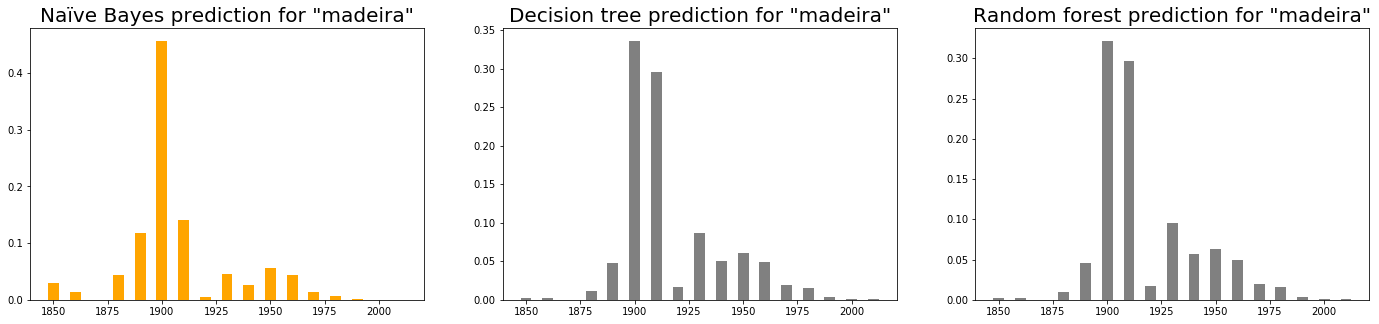

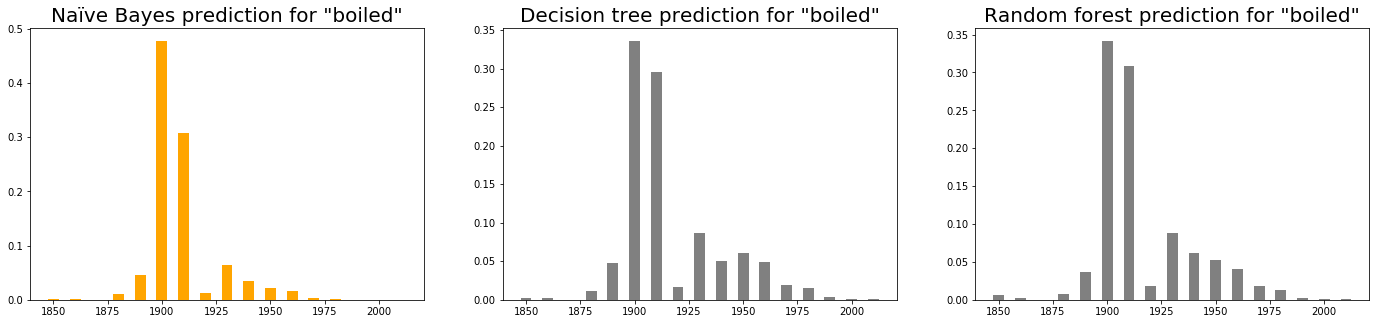

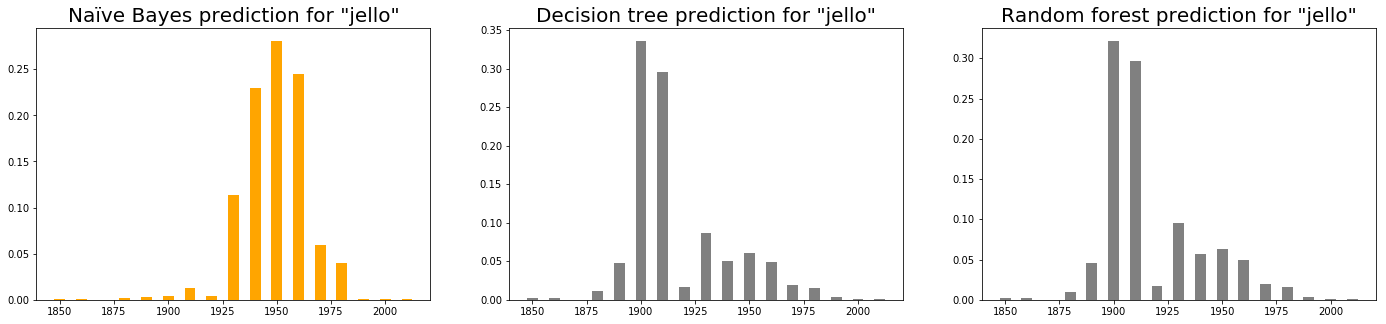

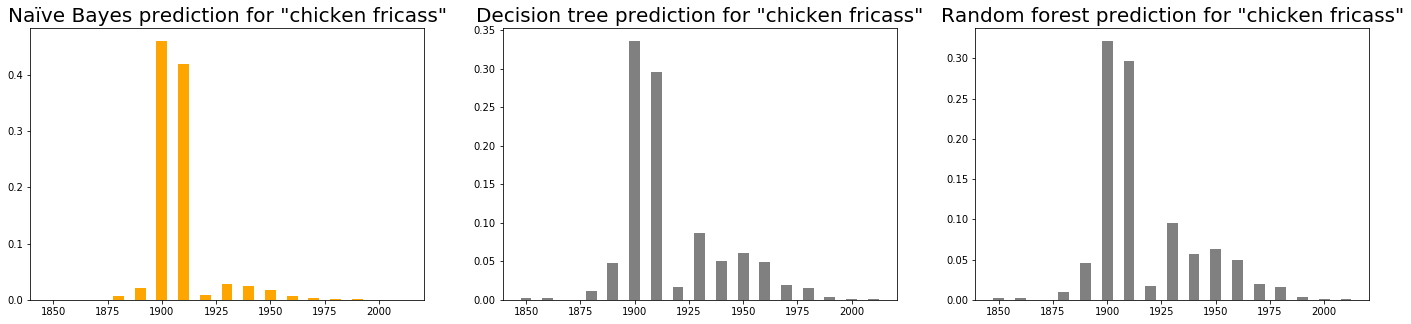

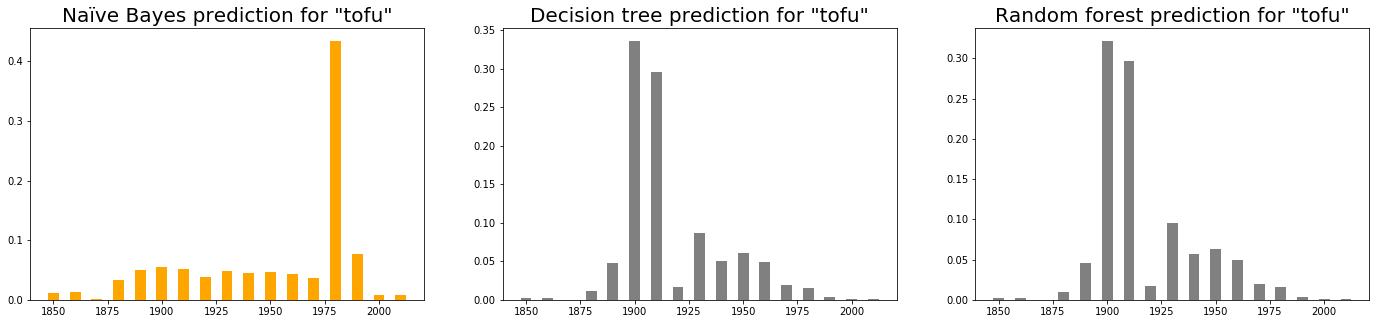

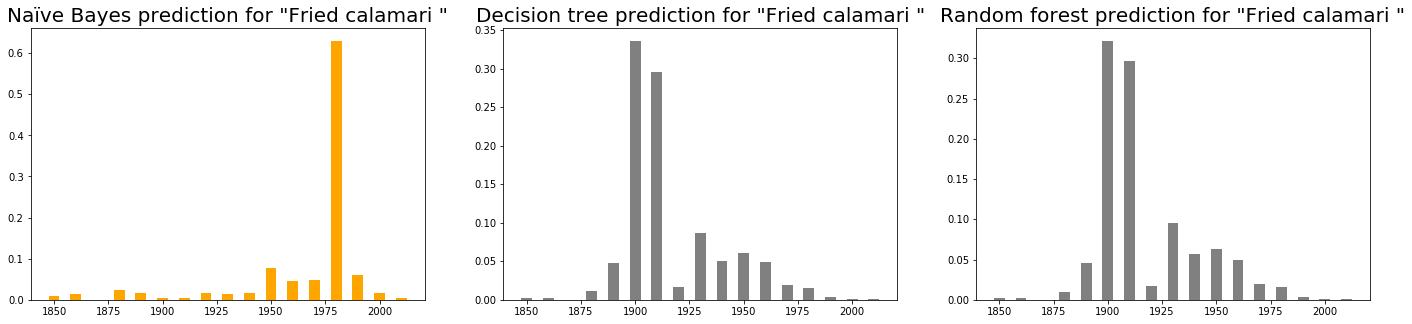

In [13]:
def predict_decade(term):
    fig, ax = plt.subplots(1, 3, figsize=(24, 5))
    for name, model, color, axis in zip(
        ["Naïve Bayes", "Decision tree", "Random forest"],
        [grid1, grid2, grid3],
        ["orange", "gray", "gray"],
        ax.ravel()):

        axis.set_title(f"{name} prediction for \"{term[:15]}\"", fontsize=20)
        axis.bar(
           list(range(1850, 2020, 10)),
           model.predict_proba([term])[0],
           width=5,
           color=color
        );

predict_decade("madeira")
predict_decade("boiled")
predict_decade("jello")
predict_decade("chicken fricassee")
predict_decade("tofu")
predict_decade("Fried calamari with house pepperoncini in a tangy dipping sauce")